In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [22]:

def read_file(filename):
    return pd.read_csv(filename, index_col=0, parse_dates=True, infer_datetime_format=True)

def get_data(timeframe):
    return read_file("../../data/btcusdt_" + timeframe + ".csv")

time_frame = "30m"
# Load data
df = get_data(time_frame)
df.head()

,open,high,low,close,volume
datetime,,,,,
2018-01-01 05:30:00,13715.65,13715.65,13400.01,13521.12,221.752443
2018-01-01 06:00:00,13500.00,13690.87,13450.00,13529.01,221.603756
2018-01-01 06:30:00,13528.99,13595.89,13402.28,13560.00,160.399291
2018-01-01 07:00:00,13559.99,13559.99,13155.38,13203.06,223.297715
2018-01-01 07:30:00,13203.00,13411.76,13202.03,13225.00,203.728509


In [23]:
df['Daily_Return'] = df['close'].pct_change()
df['Next_Day_Return'] = df['Daily_Return'].shift(-1)
window = 14
delta = df['close'].diff(1)
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=window).mean()
avg_loss = loss.rolling(window=window).mean()
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))
short_window = 12
long_window = 26
signal_window = 9
df['Short_MA'] = df['close'].rolling(window=short_window).mean()
df['Long_MA'] = df['close'].rolling(window=long_window).mean()
df['MACD'] = df['Short_MA'] - df['Long_MA']
df['Signal_Line'] = df['MACD'].rolling(window=signal_window).mean()
n = 5
df['ROC'] = df['close'].pct_change(n) * 100
df['OBV'] = np.where(df['close'] > df['close'].shift(1), df['volume'], -df['volume'])
df['OBV'] = df['OBV'].cumsum()
df_ = df.drop(['high', 'low', 'MACD', 'Short_MA', 'Long_MA'], axis=1)
df_ = df_.drop(df_.index[:50])
df_.head()

,open,close,volume,Daily_Return,Next_Day_Return,RSI,Signal_Line,ROC,OBV
datetime,,,,,,,,,
2018-01-02 06:30:00,13769.98,13686.00,249.625954,-0.004655,-0.006284,72.792229,90.978590,1.739518,923.042852
2018-01-02 07:00:00,13686.00,13600.00,267.835971,-0.006284,-0.011973,70.204390,118.903583,1.379053,655.206881
2018-01-02 07:30:00,13611.93,13437.17,443.410314,-0.011973,0.006313,59.497665,143.144202,0.427280,211.796567
2018-01-02 08:00:00,13437.11,13522.00,271.124467,0.006313,-0.009022,60.890312,161.947792,-1.299558,482.921034
2018-01-02 08:30:00,13520.32,13400.00,384.966284,-0.009022,-0.003449,50.784068,172.925114,-2.545525,97.954750


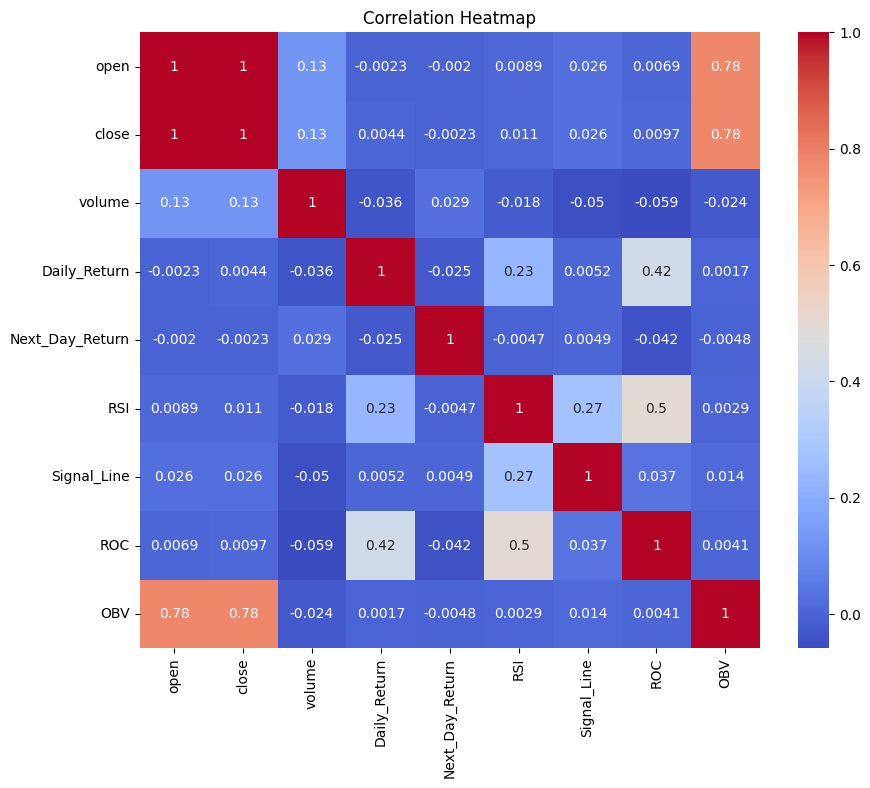

In [24]:

# Calculate the correlation matrix
correlation_matrix = df_.corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


In [25]:
df_.to_csv("../logs/junk" + time_frame + ".csv")

In [26]:
from sklearn.linear_model import LinearRegression
# Import the necessary libraries

# Create the linear regression model
model = LinearRegression()

# Define the independent variables
print
X = df_.drop('Next_Day_Return', axis=1)
X = X.drop('open', axis=1)
X = X[X['volume'] != 0]
print(X.columns)

# Define the dependent variable
y = df_['Next_Day_Return']

df_['indicator'] = 0

# Iterate over the rows in the dataframe
print(len(df_))
for i in range(5100, len(df_)-20):
    # Select the past 100 rows as training data
    X_train = X.iloc[i-5000:i-1]
    y_train = y.iloc[i-5000:i-1]

    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Make predictions on the current row
    X_test = X.iloc[i:i+1]
    y_pred = model.predict(X_test)
    df_.loc[X_test.index, 'y_pred'] = y_pred
    
    if y_pred > 0:
        df_.loc[X_test.index, 'indicator'] = 1
    if y_pred < 0:
        df_.loc[X_test.index, 'indicator'] = -1

data = df_
tot = 0
for index, _ in data.iterrows():
    data.at[index, 'signal'] = 0
    if data.at[index, 'indicator'] == 1:
        if tot == 0 or tot == -1:
            # enter long position/exit short position
            tot += 1
            data.at[index, 'signal'] = 1
    elif data.at[index, 'indicator'] == -1:
        if tot == 0 or tot == 1:
            # enter short position/exit long position
            tot -= 1
            data.at[index, 'signal'] = -1
    else:
        if tot == 1:
            # exit long position
            data.at[index, 'signal'] = -1
        elif tot == -1:
            # exit short position
            data.at[index, 'signal'] = 1
        tot = 0

data.to_csv("../logs/lin_reg_" + time_frame + ".csv")

Index(['close', 'volume', 'Daily_Return', 'RSI', 'Signal_Line', 'ROC', 'OBV'], dtype='object')
70349


In [27]:
print(model.coef_)

[-5.86818425e-09  3.55882825e-08 -2.42766556e-01 -9.66426765e-06
  4.09430405e-07  2.61661430e-03  1.15796835e-09]


In [20]:
correlation = df_.iloc[300:]['Next_Day_Return'].corr(df_.iloc[300:]['y_pred'])
print(correlation)


-0.03474512086485524
